# 从MHA,MQA,GQA到MLA

## 主要内容
1. 苏剑林. (May. 13, 2024). [《缓存与效果的极限拉扯：从MHA、MQA、GQA到MLA 》](https://kexue.fm/archives/10091)
   - Multi-Head Attention
   - Multi-Query Attention
   - Group-Query Attention
   - Multi-Head Latent Attention
   - *RoPE
   - *KV Cache
2. 代码实现
3. 图解

## 定位
1. 博客介绍
2. 代码练手和知识梳理
-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

## MHA

MHA（Multi-Head Attention），也就是多头注意力，是开山之作《Attention is all you need》所提出的一种Attention形式，可以说它是当前主流LLM的基础工作。在数学上，多头注意力MHA等价于多个独立的单头注意力的拼接，假设输入的（行）向量序列为$x_1,x_2,⋯,x_l$
，其中$x_i\in R^d$
，那么MHA可以形式地记为
$$\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{(s)} ,\boldsymbol{v}_{\leq t}^{(s)}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)\boldsymbol{v}_i^{(s)}}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d \times d_k} \\ 
\boldsymbol{k}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_k^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_k^{(s)}\in\mathbb{R}^{d \times d_k} \\ 
\boldsymbol{v}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d\times d_v} 
\end{gathered} 
\end{equation}$$
 

简单起见，这里省略了Attention矩阵的缩放因子。实践上，常见的设置是$d_k = d_v = d / h$，对于LLAMA2-7b有$d=4096,h=32,d_k=d_v=128$，LLAMA2-70b则是$d=8192,h=64, d_k = d_v = 128$
由于这里只考虑了主流的自回归LLM所用的Causal Attention，因此在token by token递归生成时，新预测出来的第t+1个token，并不会影响到已经算好的$k^{(s)}_{≤t},v^{(s)}_{≤t}$，因此这部分结果我们可以缓存下来供后续生成调用，避免不必要的重复计算，这就是所谓的KV Cache。

而后面的MQA、GQA、MLA，都是围绕**“如何减少KV Cache同时尽可能地保证效果”**这个主题发展而来的产物。

![MHA](mha.png)

In [ ]:
class MHA(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert d_model % num_heads == 0
        self.head_dim = d_model // num_heads

        self.q_linear = nn.ModuleList([nn.Linear(d_model, self.head_dim, bias=False) for _ in range(num_heads)])
        self.k_linear = nn.ModuleList([nn.Linear(d_model, self.head_dim, bias=False) for _ in range(num_heads)])
        self.v_linear = nn.ModuleList([nn.Linear(d_model, self.head_dim, bias=False) for _ in range(num_heads)])
        self.out_linear = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        outputs = []

        # Parallel
        for s in range(self.num_heads):
            q = self.q_linear[s](x) # (batch_size, seq_len, head_dim)
            k = self.k_linear[s](x)
            v = self.v_linear[s](x) # (batch_size, seq_len, head_dim)

            # RoPE
            # TODO: Implement RoPE

            # Attention
            attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # (batch_size, seq_len, seq_len)

            # # Causal mask
            mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
            mask = mask.unsqueeze(0).to(x.device)   # (1, seq_len, seq_len)
            attention = attention.masked_fill(mask, float('-inf'))
            attention = torch.softmax(attention, dim=-1)
            
            # Output
            output = torch.matmul(attention, v) # (batch_size, seq_len, head_dim)
            outputs.append(output)

        # Linear projection
        output = torch.cat(outputs, dim=-1) # (batch_size, seq_len, d_model)
        output = self.out_linear(output)
        
        return output


class MHA2(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert d_model % num_heads == 0
        self.head_dim = d_model // num_heads

        self.q_linear = nn.Linear(d_model, num_heads * self.head_dim, bias=False)
        self.k_linear = nn.Linear(d_model, num_heads * self.head_dim, bias=False)
        self.v_linear = nn.Linear(d_model, num_heads * self.head_dim, bias=False)
        self.out_linear = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        q = self.q_linear(x)
        k = self.k_linear(x)
        v = self.v_linear(x) # (batch_size, seq_len, num_heads * head_dim)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)  
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim) 
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim) 
        # (batch_size, seq_len, num_heads, head_dim)

        # RoPE
        # TODO: Implement RoPE

        # Attention
        attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # (batch_size, seq_len, seq_len)

        # Causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        mask = mask.unsqueeze(0).to(x.device)   # (1, seq_len, seq_len)
        attention = attention.masked_fill(mask, float('-inf'))
        attention = torch.softmax(attention, dim=-1)

        # Output
        output = torch.matmul(attention, v) # (batch_size, seq_len, num_heads, head_dim)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1) # (batch_size, seq_len, d_model)
        output = self.out_linear(output)

        return output
# Example usage
d_model = 512
num_heads = 8
mha = MHA(d_model, num_heads)
x = torch.randn(10, 20, d_model)  # (batch_size, sequence_length, d_model)
output = mha(x)
print(output.shape)  # Should be (10, 20, 512)

## 瓶颈
一个自然的问题是：**为什么降低KV Cache的大小如此重要？**

众所周知，一般情况下LLM的推理都是在GPU上进行，单张GPU的显存是有限的，一部分我们要用来存放模型的参数和前向计算的激活值，这部分依赖于模型的体量，选定模型后它就是个常数；另外一部分我们要用来存放模型的KV Cache，这部分不仅依赖于模型的体量，还依赖于模型的输入长度，也就是在推理过程中是动态增长的，当Context长度足够长时，它的大小就会占主导地位，可能超出一张卡甚至一台机（8张卡）的总显存量。

在GPU上部署模型的原则是：能一张卡部署的，就不要跨多张卡；能一台机部署的，就不要跨多台机。这是因为“卡内通信带宽 > 卡间通信带宽 > 机间通信带宽”，由于“木桶效应”，模型部署时跨的设备越多，受设备间通信带宽的的“拖累”就越大，事实上即便是单卡H100内SRAM与HBM的带宽已经达到了3TB/s，但对于Short Context来说这个速度依然还是推理的瓶颈，更不用说更慢的卡间、机间通信了。

所以，减少KV Cache的目的就是要实现在更少的设备上推理更长的Context，或者在相同的Context长度下让推理的batch size更大，从而实现更快的推理速度或者更大的吞吐总量。当然，最终目的都是为了实现更低的推理成本。

要想更详细地了解这个问题，读者可以进一步阅读《FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness》、《A guide to LLM inference and performance》、《LLM inference speed of light》等文章，这里就不继续展开了（主要是笔者水平也有限，唯恐说多错多）。

[【8】KV Cache 原理讲解](https://www.bilibili.com/video/BV17CPkeEEzk/)

## MQA

MQA，即“**M**ulti-**Q**uery **A**ttention”，是减少KV Cache的一次非常朴素的尝试，首次提出自《Fast Transformer Decoding: One Write-Head is All You Need》，这已经是2019年的论文了，这也意味着早在LLM火热之前，减少KV Cache就已经是研究人员非常关注的一个课题了。

MQA的思路很简单，直接让所有Attention Head共享同一个K、V，用公式来说，就是取消MHA所有的$k,v$的上标$(s)$：

$$
\begin{equation}
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t},\boldsymbol{v}_{\leq t}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i{}^{\top}\right)\boldsymbol{v}_i}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d \times d_k} \\ 
\boldsymbol{k}_i = \boldsymbol{x}_i\boldsymbol{W}_k\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_k\in\mathbb{R}^{d \times d_k} \\ 
\boldsymbol{v}_i = \boldsymbol{x}_i\boldsymbol{W}_v\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v\in\mathbb{R}^{d\times d_v} 
\end{gathered} 
\end{equation}
$$

使用MQA的模型包括PaLM、StarCoder、Gemini等。很明显，MQA直接将KV Cache减少到了原来的1/h
，这是非常可观的，单从节省显存角度看已经是天花板了。

效果方面，目前看来大部分任务的损失都比较有限，且MQA的支持者相信这部分损失可以通过进一步训练来弥补回。此外，注意到MQA由于共享了K、V，将会导致Attention的参数量减少了将近一半，而为了模型总参数量的不变，通常会相应地增大FFN/GLU的规模，这也能弥补一部分效果损失。
![MQA](mqa.png)

In [ ]:
class MQA(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert d_model % num_heads == 0
        self.head_dim = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, self.head_dim)
        self.v_linear = nn.Linear(d_model, self.head_dim)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear projections, all heads share the same K, V
        q = self.q_linear(x)    # (b, len, d_model)
        k = self.k_linear(x)    # (b, len, head_dim)
        v = self.v_linear(x)    # (b, len, head_dim)
        # Reshape for multi-head attention
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2) 
        # (b, head, len, head_dim)
        k = torch.unsqueeze(k, 1)  # (b, 1, len, head_dim)
        v = torch.unsqueeze(v, 1)  # (b, 1, len, head_dim)

        # Attention 
        # print(q.shape, k.shape)
        attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # (b, head, len, len)
        attention = torch.softmax(attention, dim=-1)

        # Output
        output = torch.matmul(attention, v) # (b, head, len, head_dim)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Linear projection
        output = self.out_linear(output)

        return output

# Example usage
d_model = 512
num_heads = 8
mqa = MQA(d_model, num_heads)
x = torch.randn(10, 20, d_model)  # (batch_size, sequence_length, d_model)
output = mqa(x)
print(output.shape)  # Should be (10, 20, 512)

## GQA  
然而，也有人担心MQA对KV Cache的压缩太严重，以至于会影响模型的学习效率以及最终效果。为此，一个MHA与MQA之间的过渡版本GQA（**G**rouped-**Q**uery **A**ttention）应运而生，出自论文《GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints》，是去年的工作。

事后看来，GQA的思想也很朴素，它就是将所有Head分为g个组（g可以整除h），每组共享同一对K、V，用数学公式表示为
$$
\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{\color{red}{(\lceil sg/h\rceil)}} ,\boldsymbol{v}_{\leq t}^{\color{red}{(\lceil sg/h\rceil)}}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{\color{red}{(\lceil sg/h\rceil)}}{}^{\top}\right)\boldsymbol{v}_i^{\color{red}{(\lceil sg/h\rceil)}}}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{\color{red}{(\lceil sg/h\rceil)}}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d\times d_k} \\ 
\boldsymbol{k}_i^{\color{red}{(\lceil sg/h\rceil)}} = \boldsymbol{x}_i\boldsymbol{W}_k^{\color{red}{(\lceil sg/h\rceil)}}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_k^{\color{red}{(\lceil sg/h\rceil)}}\in\mathbb{R}^{d\times d_k} \\ 
\boldsymbol{v}_i^{\color{red}{(\lceil sg/h\rceil)}} = \boldsymbol{x}_i\boldsymbol{W}_v^{\color{red}{(\lceil sg/h\rceil)}}\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v^{\color{red}{(\lceil sg/h\rceil)}}\in\mathbb{R}^{d\times d_v} 
\end{gathered} 
\end{equation}
$$

这里的$\lceil \cdot\rceil$是上取整符号。GQA提供了MHA到MQA的自然过渡，当g=h时就是MHA，g=1时就是MQA，当$1<g<h$时，它只将KV Cache压缩到$g/h$，压缩率不如MQA，但同时也提供了更大的自由度，效果上更有保证。GQA最知名的使用者，大概是Meta开源的LLAMA2-70B，以及LLAMA3全系列，此外使用GQA的模型还有TigerBot、DeepSeek-V1、StarCoder2、Yi、ChatGLM2、ChatGLM3等，相比使用MQA的模型更多（ChatGLM虽然在它的介绍中说自己是MQA，但实际是$g=2$的GQA）。

在llama2/3-70B中，GQA的$g=8$，其他用了GQA的同体量模型基本上也保持了这个设置，这并非偶然，而是同样出于推理效率的考虑。我们知道，70B这个体量的模型，如果不进行极端的量化，那么不可能部署到单卡（A100/H100 80G）上。单卡不行，那么就能单机了，一般情况下一台机可以装8张卡，刚才我们说了，Attention的每个Head实际上是独立运算然后拼接起来的，当$g=8$时，正好可以每张卡负责计算一组K、V对应的Attention Head，这样可以在尽可能保证K、V多样性的同时最大程度上减少卡间通信。

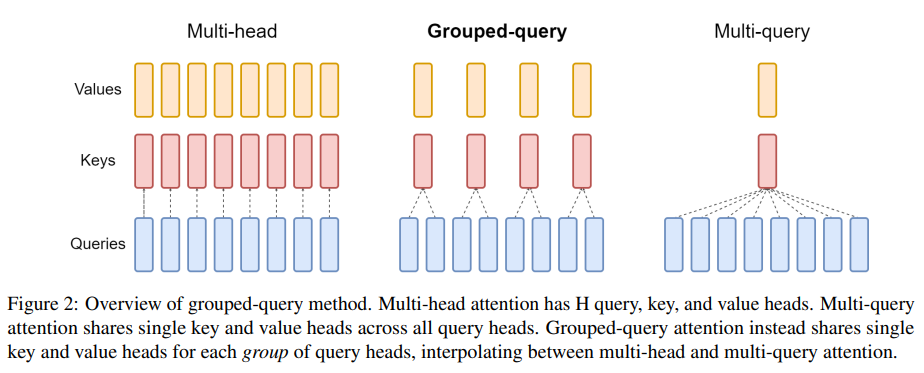
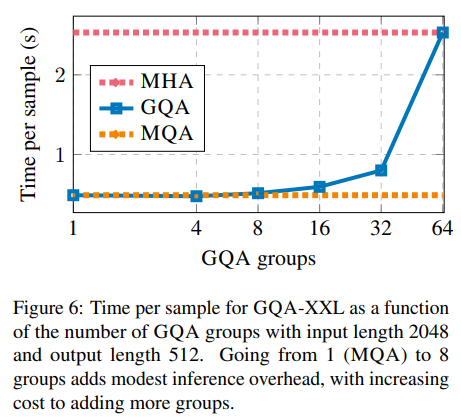
![GQA](gqa.png)

In [7]:
class GQA(nn.Module):
    def __init__(self, d_model, num_heads, num_groups):
        super(GQA, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_groups = num_groups

        self.group_heads = num_heads // num_groups
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, self.head_dim * num_groups)
        self.W_v = nn.Linear(d_model, self.head_dim * num_groups)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Linear projections, all heads share the same K, V
        q = self.W_q(x)    # (b, len, d_model)
        k = self.W_k(x)    # (b, len, head_dim * num_groups)
        v = self.W_v(x)    # (b, len, head_dim * num_groups)
        
        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_groups, self.group_heads, self.head_dim).permute(0, 2, 3, 1, 4) # (b, len, group, g_heads, head_dim) -> (b, group, g_heads, len, head_dim)
        k = k.view(batch_size, seq_len, self.num_groups, self.head_dim).transpose(1, 2)      # (b, group, len, head_dim)
        v = v.view(batch_size, seq_len, self.num_groups, self.head_dim).transpose(1, 2)      # (b, group, len, head_dim)
        
        k = torch.unsqueeze(k, 2) # (b, group, 1, len, head_dim)
        v = torch.unsqueeze(v, 2) # (b, group, 1, len, head_dim)

        # Attention 
        attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # (b, group, g_heads, len, len)
        attention = torch.softmax(attention, dim=-1)

        # Output
        output = torch.matmul(attention, v) # (b, group, g_heads, len, head_dim)
        output = output.permute(0, 3, 1, 2, 4).contiguous().view(batch_size, -1, self.d_model)

        # Linear projection
        output = self.out_linear(output)

        return output


# Example usage
d_model = 512
num_heads = 8
num_groups = 4

gqa = GQA(d_model, num_heads, num_groups)
input_tensor = torch.randn(32, 10, d_model)  # (batch_size, sequence_length, d_model)
output_tensor = gqa(input_tensor)
print(output_tensor.shape)  # Output: torch.Size([32, 10, 512])

torch.Size([32, 10, 512])


## MLA

有了MHA、MQA、GQA的铺垫，我们理解MLA（Multi-head Latent Attention）就相对容易一些了。DeepSeek-V2的技术报告里是从低秩投影的角度引入MLA的，以至于有部分读者提出“为什么LoRA提出这么久了，直到MLA才提出对KV Cache低秩分解的做法”之类的疑问。

然而，笔者认为低秩投影这个角度并不贴近本质，因为要说低秩投影的话，事实上只要我们将GQA的所有K、V叠在一起，就会发现GQA也相当于在做低秩投影：
$$\begin{equation}\underbrace{\left[\boldsymbol{k}_i^{(1)},\cdots,\boldsymbol{k}_i^{(g)},\boldsymbol{v}_i^{(1)},\cdots,\boldsymbol{v}_i^{(g)}\right]}_{\boldsymbol{c}_i\in\mathbb{R}^{g(d_k+d_v)}} = \boldsymbol{x}_i \underbrace{\left[\boldsymbol{W}_k^{(1)},\cdots,\boldsymbol{W}_k^{(g)},\boldsymbol{W}_v^{(1)},\cdots,\boldsymbol{W}_v^{(g)}\right]}_{\boldsymbol{W}_c\in\mathbb{R}^{d\times g(d_k+d_v)}}\end{equation}$$

这里我们将所有$\boldsymbol{k}_i^{(s)},\boldsymbol{v}_i^{(s)}$拼在一起记为$c_i$，相应的投影矩阵也拼在一起记为$\boldsymbol{W}_c$，注意到一般都有$d_c = g(d_k+d_v) < d$，所以$x_i$到$c_i$的变换就是一个低秩投影。所以，MLA的本质改进不是低秩投影，而是低秩投影之后的工作。
### Part 1
GQA在投影之后做了什么呢？首先它将向量对半分为两份分别作为K、V，然后每一份又均分为$g$份，每一份复制$h/g$次，以此来“凑”够$h$个Attention Head所需要的K、V。我们知道分割、复制都是简单的线性变换，所以MLA的第一个想法是将这些简单的线性变换换成一般的线性变换，以增强模型的能力：
$$
\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{(s)} ,\boldsymbol{v}_{\leq t}^{(s)}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)\boldsymbol{v}_i^{(s)}}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_q^{(s)}\in\mathbb{R}^{d}\\ 
\boldsymbol{k}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_k^{(s)}\in\mathbb{R}^{d_k},\quad \boldsymbol{W}_k^{(s)}\in\mathbb{R}^{d_c} \\ 
\boldsymbol{v}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_c\times d_v} \\[10pt] 
\boldsymbol{c}_i = \boldsymbol{x}_i \boldsymbol{W}_c\in\mathbb{R}^{d_c},\quad \boldsymbol{W}_c\in\mathbb{R}^{d\times d_c} 
\end{gathered} 
\end{equation}
$$

#### MQA和GQA的“升维”投影矩阵
> 原始的GQA先将输入$x_i$分别压缩到$gd_k$和$g\cdot d_v$维，再复制$g$份得到可以直接和$q_i$相乘的$k_i$和$v_i$。为了对照MLA，此处我们沿用博客中的记号，将GQA的投影矩阵记为$\boldsymbol{W}_c$，那么有：
> $$
> \boldsymbol{c}_i = \boldsymbol{x}_i \boldsymbol{W}_c \in \mathbb{R}^{g(d_k+d_v)},\quad \boldsymbol{W}_c\in\mathbb{R}^{d\times g(d_k+d_v)}\\
> 
> \boldsymbol{c}_i = [\boldsymbol{k}_i^{(1)}, \cdots, \boldsymbol{k}_i^{(g)}, \boldsymbol{v}_i^{(1)}, \cdots, \boldsymbol{v}_i^{(g)}] = [\boldsymbol{ck}_i, \boldsymbol{cv}_i]\\
> 
> \boldsymbol{W}_{split}^k = \begin{bmatrix}
> \boldsymbol{I}_{gd_k} \\
> \boldsymbol{0}_{gd_k}
> \end{bmatrix} \quad
> 
> \boldsymbol{W}_{split}^v = \begin{bmatrix}
> \boldsymbol{0}_{gd_v} \\
> \boldsymbol{I}_{gd_v}
> \end{bmatrix} \\
> 
> \boldsymbol{ck}_i = \boldsymbol{c}_i \boldsymbol{W}_{split}^k \in \mathbb{R}^{gd_k},\quad \boldsymbol{cv}_i = \boldsymbol{c}_i \boldsymbol{W}_{split}^v \in \mathbb{R}^{gd_v}\\
> $$
> 这里$\boldsymbol{W}_{split}^k,\boldsymbol{W}_{split}^v$实现了形式上的分割操作，得到$\boldsymbol{ck}_i, \boldsymbol{cv}_i$。下面我们将构造“复制”操作的投影矩阵：
> $$
> \boldsymbol{W}_k \in \mathbb{R}^{g d_k\times h d_k}= \begin{bmatrix}
> \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k} & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } \\
> \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } \\
> \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
> \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k}
> \end{bmatrix}
> $$
> 其中每行$\boldsymbol{I}_{d_k}$重复$h/g$遍，代表从groups到heads的“放缩”倍数或“复制”次数；一共有$g$行，对应原来的$d_i^{(s)}$，共$g$个。$\boldsymbol{W}_v \in \mathbb{R}^{g d_v\times h d_v}$的形式与$\boldsymbol{W}_k$相同，故不赘述。将前者右乘$\boldsymbol{ck}_i$，则有：
> 
> $$
> \boldsymbol{ck}_i \boldsymbol{W}_k = [\boldsymbol{k}_i^{(1)}, \cdots, \boldsymbol{k}_i^{(g)}] \cdot \begin{bmatrix}
> \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k} & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } \\
> \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } \\
> \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
> \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{0}_{d_k } & \cdots & \boldsymbol{I}_{d_k} & \boldsymbol{I}_{d_k} & \cdots & \boldsymbol{I}_{d_k}
> \end{bmatrix}\\
> 
> =[\boldsymbol{k}_i^{(1)} \boldsymbol{I}_{d_k}, \boldsymbol{k}_i^{(1)}  \boldsymbol{I}_{d_k}, \cdots,\boldsymbol{k}_i^{(1)} \boldsymbol{I}_{d_k},\boldsymbol{k}_i^{(2)} \boldsymbol{I}_{d_k},\boldsymbol{k}_i^{(2)} \boldsymbol{I}_{d_k},\cdots,\boldsymbol{k}_i^{(2)}  \boldsymbol{I}_{d_k},\cdots,\boldsymbol{k}_i^{(g)} \boldsymbol{I}_{d_k},\boldsymbol{k}_i^{(g)} \boldsymbol{I}_{d_k},\cdots,\boldsymbol{k}_i^{(g)} \boldsymbol{I}_{d_k}]\\
> 
> =[\boldsymbol{k}_i^{(1)}, \cdots, \boldsymbol{k}_i^{(1)},\boldsymbol{k}_i^{(2)}, \cdots, \boldsymbol{k}_i^{(2)},\cdots,\boldsymbol{k}_i^{(g)}, \cdots, \boldsymbol{k}_i^{(g)}] \in \mathbb{R}^{h d_k}
> $$
> 于是我们就得到了维度为$h d_k$的$\boldsymbol{k}_i$，其中每个$\boldsymbol{k}_i^{(s)}$都被复制了$h/g$次，实现了“复制”操作。同理，$\boldsymbol{cv}_i \boldsymbol{W}_v$得到$\boldsymbol{v}_i$，维度为$h d_v$。
> 这里我们讨论的都是单个token的行向量，而对于实际输入序列，其（最后两个）维度为(seq_len, d)，同样可以直接替换上面的单一向量。
> 在上面所构造的所有矩阵中，最重要的是$\boldsymbol{W}_k$和$\boldsymbol{W}_v$，可以看出两者都是由若干单位矩阵组成的稀疏矩阵，是GQA的分割、复制操作的矩阵形式描述，那么正如博客中所述，我们可以将让这两个矩阵变成可学习的参数，比如在“复制”过程中给每个头一个不同的权重，这样理论上可以增强GQA的能力。

然而，理论上这样是能增加模型能力，但别忘了GQA的主要目的是减少KV Cache，出于节省计算和通信成本的考虑，我们一般会缓存的是投影后的$k_i,v_i$而不是投影前的$c_i$或$x_i$，而MLA的这个做法，通过不同的投影矩阵再次让所有的K、V Head都变得各不相同，那么KV Cache的大小就恢复成跟MHA一样大了，违背了GQA的初衷。

对此，MLA发现，我们可以结合Dot-Attention的具体形式，通过一个简单但不失巧妙的恒等变换来规避这个问题。首先，在训练阶段还是照常进行，此时优化空间不大；然后，在推理阶段，我们利用
$$\begin{equation}\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top} = \left(\boldsymbol{x}_t\boldsymbol{W}_q^{(s)}\right) \left(\boldsymbol{c}_i\boldsymbol{W}_k^{(s)}\right){}^{\top} = \boldsymbol{x}_t\left(\boldsymbol{W}_q^{(s)}\boldsymbol{W}_k^{(s)}{}^{\top}\right)\boldsymbol{c}_i^{\top} \end{equation}$$
这意味着推理阶段，**我们可以将$\boldsymbol{W}_q^{(s)}\boldsymbol{W}_k^{(s)}{}^{\top}$合并起来作为Q的投影矩阵**，那么$c_i$则取代了原本的$k_i$，同理，在$o_t$后面我们还有一个投影矩阵，于是$\boldsymbol{v}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_v^{(s)}$的$\boldsymbol{W}_v^{(s)}$也可以吸收到后面的投影矩阵中去，于是等效地$v_i$也可以用$c_i$代替，也就是说此时KV Cache只需要存下所有的$c_i$就行，而不至于存下所有的$k^{(s)}_i$、$v^{(s)}_i$。注意到$c_i$跟$(s)$无关，也就是说是所有头共享的，即MLA在推理阶段它可以恒等变换为一个MQA。


> $$
> o_t = Softmax \frac{(q_tk^{\top}_t)}{\sqrt{d}}v_t\\
> u_t = o_tW_o = Softmax \frac{x_tW_q(c^{kv}_tW_k)^{\top}}{\sqrt{d}}(c^{kv}_tW_v)W_o\\
> = Softmax \frac{(x_t W_q W^{\top}_k) c^{kv\top}_t}{\sqrt{d}}c^{kv}_t(W_vW_o)
> $$


再次强调，本文的主题是一直都是减少KV Cache，那到目前为止，MLA做到了什么呢？答案是通过不同的投影矩阵来增强了GQA的能力，并且推理时可以保持同样大小的KV Cache。那么反过来，如果我们只需要跟GQA相近的能力，那么是不是就可以再次减少KV Cache了？换言之，$d_c$没必要取$g(d_k+d_v)$，而是取更小的值（DeepSeek-V2取了512），从而进一步压缩KV Cache，这就是MLA的核心思想。

（注：这里有一个细节，就是$\boldsymbol{W}_q^{(s)}\boldsymbol{W}_k^{(s)}{}^{\top}$合并成一个矩阵的恒等变换，理论上只有在无限精度下才成立，实际上如果我们使用单精度尤其是BF16的话，经过变换后的精度损失往往还是挺明显的，经过多层累积后可能放大到比较可观的程度，这里可能要根据实际误差看要不要做一些后处理。）



### Part 2
一切似乎都很完美，看上去一个又好又省的理想设计就要出炉了。不过别急，当我们再深入思考一下就会发现，到目前为止的MLA有一个难以绕开的缺陷——不兼容[RoPE（旋转位置编码）](https://kexue.fm/archives/8265)。
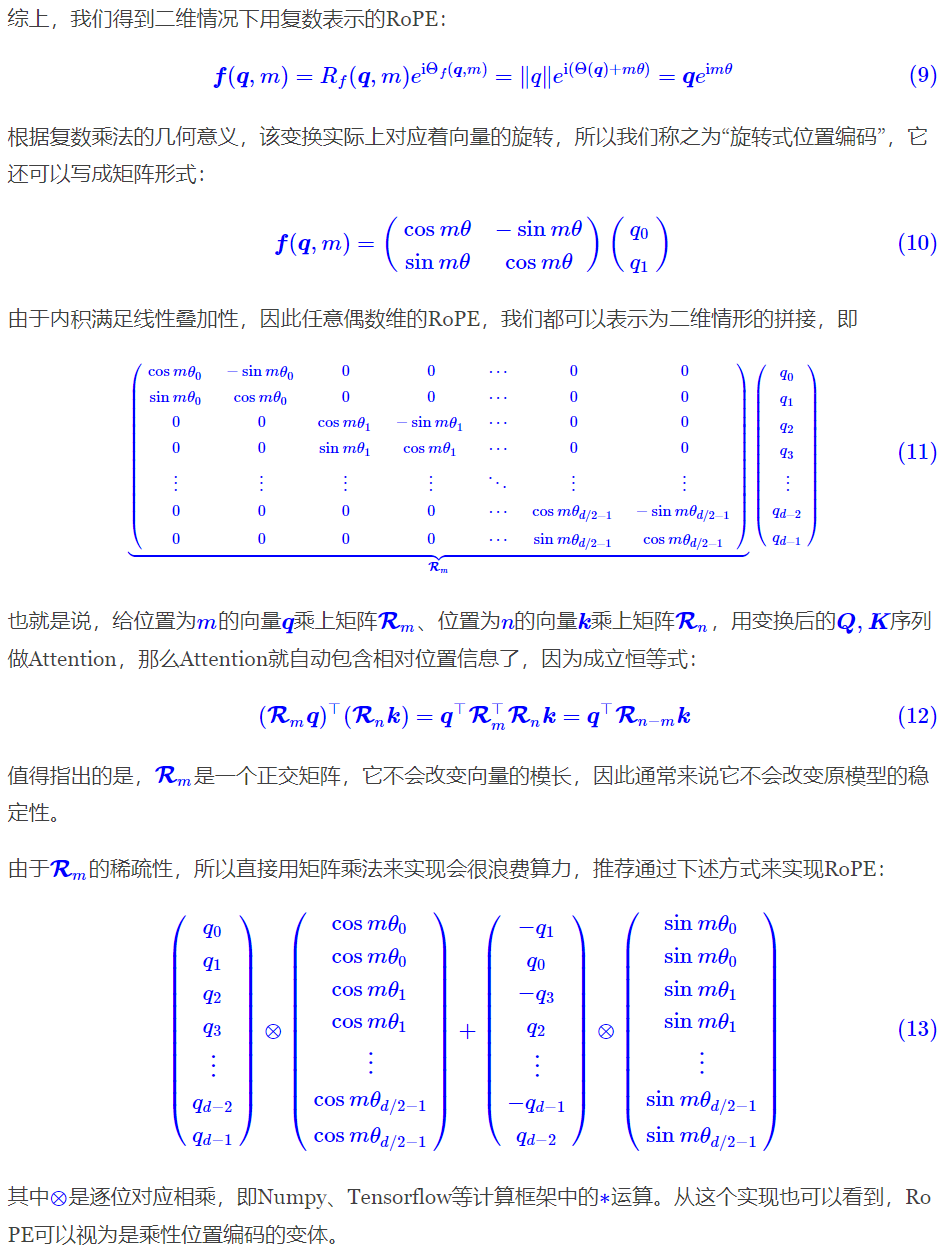

刚才我们说了，MLA之所以能保持跟GQA一样大小的KV Cache，其关键一步是“将$\boldsymbol{W}_q^{(s)}\boldsymbol{W}_k^{(s)}{}^{\top}$合并成一个（跟位置无关的）矩阵作为Q的投影矩阵”，但如果加了RoPE的话，这一步就无法实现了。这是因为RoPE是一个跟位置相关的、$d_k$的分块对角矩阵$\boldsymbol{\mathcal{R}}_m$，满足$\boldsymbol{\mathcal{R}}_m\boldsymbol{\mathcal{R}}_n^{\top}=\boldsymbol{\mathcal{R}}_{m-n}$，MLA加入RoPE之后会让$\boldsymbol{W}_q^{(s)}\boldsymbol{W}_k^{(s)}{}^{\top}$之间多插入了一项$\boldsymbol{\mathcal{R}}_{t-1}$：

$$
\begin{split} 
\boldsymbol{q}_i^{(s)} = \boldsymbol{x}_i\boldsymbol{W}_q^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i}\quad &,\quad\boldsymbol{k}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_k^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i} \\ 
\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top} = \left(\boldsymbol{x}_t\boldsymbol{W}_q^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_t} \right) \left(\boldsymbol{c}_i\boldsymbol{W}_k^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i} \right){}^{\top} &= \boldsymbol{x}_t \left( \boldsymbol{W}_q^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R_{t-i}}}} \boldsymbol{W}_k^{(s)}{}^{\top} \right)\boldsymbol{c}_i^{\top} \end{split}
$$

这里的$\boldsymbol{W}_q^{(s)}\boldsymbol{\mathcal{R}}_{t-i} \boldsymbol{W}_k^{(s)}{}^{\top}$就无法合并为一个固定的投影矩阵了（跟位置差$t−i$相关），从而MLA的想法无法结合RoPE实现。

前段时间，笔者也很荣幸跟DeepSeek团队讨论过这个问题，但这个问题可以说非常本质，所以当时笔者实际上也没能提出什么有效的建议。最简单的方式是放弃RoPE，换用其他基于Attention Bias的位置编码，如ALIBI，但DeepSeek的实验显示它明显不如RoPE（注意，MLA不是不能加RoPE，而是加了RoPE之后无法用恒等变换技巧来减少KV Cache），笔者也提议过换Sandwich，它不像ALIBI单调衰减到负无穷，估计效果会好些，但感觉是治标不治本。还有一个折中的办法是将$q_i$的输入也改为$c_i$，然后RoPE加在$c_i$之后，即
$$\begin{equation}\boldsymbol{q}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{\mathcal{R}}_i\boldsymbol{W}_q^{(s)},\quad\boldsymbol{k}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{\mathcal{R}}_i\boldsymbol{W}_k^{(s)}\end{equation}$$

这样$\boldsymbol{\mathcal{R}}_i$就可以吸收到$c_i$
中去，但这样就没有$\boldsymbol{\mathcal{R}}_m\boldsymbol{\mathcal{R}}_n^{\top}=\boldsymbol{\mathcal{R}}_{m-n}$
的运算了，此时的RoPE不再是通过绝对位置实现相对位置，而单纯是在Q、K上加绝对位置，让模型自己想办法提炼相对位置信息。

最后发布的MLA，采取了一种混合的方法——每个Attention Head的Q、K新增dr
个维度用来添加RoPE，其中K新增的维度每个Head共享：
$$\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{(s)} ,\boldsymbol{v}_{\leq t}^{(s)}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)\boldsymbol{v}_i^{(s)}}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \left[\boldsymbol{x}_i\boldsymbol{W}_{qc}^{(s)}, \boldsymbol{x}_i\boldsymbol{W}_{qr}^{(s)}\boldsymbol{\mathcal{R}}_i\right]\in\mathbb{R}^{d_k + d_r},\quad \boldsymbol{W}_{qc}^{(s)}\in\mathbb{R}^{d},\boldsymbol{W}_{qr}^{(s)}\in\mathbb{R}^{d\times d_r}\\ 
\boldsymbol{k}_i^{(s)} = \left[\boldsymbol{c}_i\boldsymbol{W}_{kc}^{(s)}, \boldsymbol{x}_i\boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\boldsymbol{\mathcal{R}}_i\right]\in\mathbb{R}^{d_k+d_r},\quad \boldsymbol{W}_{kc}^{(s)}\in\mathbb{R}^{d_c}, \boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\in\mathbb{R}^{d\times d_r} \\ 
\boldsymbol{v}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_c\times d_v} \\[10pt] 
\boldsymbol{c}_i = \boldsymbol{x}_i \boldsymbol{W}_c\in\mathbb{R}^{d_c},\quad \boldsymbol{W}_c\in\mathbb{R}^{d\times d_c} 
\end{gathered} 
\end{equation}$$
 
这样一来，没有RoPE的维度就可以重复“Part 1”的操作，在推理时KV Cache只需要存$c_i$，新增的带RoPE的维度就可以用来补充位置信息，并且由于所有Head共享，所以也就只有在K Cache这里增加了$d_r$个维度，原论文取了$d_r=d_k/2=64$，相比原本的$d_c=512$，增加的幅度不大。


$$
\begin{split}
q^{(s)}_i k^{(s)\top}_j = [x_iW^{(s)}_{qc}(c_iW^{(s)}_{kc})^{\top}&, x_iW^{(s)}_{qr}\mathcal{R}_i(x_iW_{kr}\mathcal{R}_j)^{\top}]\\
=[x_iW^{(s)}_{qc}W^{(s)\top}_{kc}c_i^{\top}, x_i&W^{(s)}_{qr}\mathcal{R}_{i-j}W_{kr}^{\top}c_i^{\top}]
\end{split}
$$

### Part 3
最后有一个细节，就是MLA的最终版本，还将Q的输入也改为了低秩投影形式，这与减少KV Cache无关，主要是为了减少训练期间参数量和相应的梯度（原论文说的是激活值，个人表示不大理解）所占的显存：
$$
\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}, \boldsymbol{o}_t^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{(s)} ,\boldsymbol{v}_{\leq t}^{(s)}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)\boldsymbol{v}_i^{(s)}}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{(s)}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \left[\boldsymbol{c}_i'\boldsymbol{W}_{qc}^{(s)}, \boldsymbol{c}_i'\boldsymbol{W}_{qr}^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i}\right]\in\mathbb{R}^{d_k + d_r},\quad \boldsymbol{W}_{qc}^{(s)}\in\mathbb{R}^{d_c'},\boldsymbol{W}_{qr}^{(s)}\in\mathbb{R}^{d_c'\times d_r}\\ 
\boldsymbol{k}_i^{(s)} = \left[\boldsymbol{c}_i\boldsymbol{W}_{kc}^{(s)}, \boldsymbol{x}_i\boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i}\right]\in\mathbb{R}^{d_k+d_r},\quad \boldsymbol{W}_{kc}^{(s)}\in\mathbb{R}^{d_c}, \boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\in\mathbb{R}^{d\times d_r} \\ 
\boldsymbol{v}_i^{(s)} = \boldsymbol{c}_i\boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_v},\quad \boldsymbol{W}_v^{(s)}\in\mathbb{R}^{d_c\times d_v} \\[10pt] 
\boldsymbol{c}_i' = \boldsymbol{x}_i \boldsymbol{W}_c'\in\mathbb{R}^{d_c'},\quad \boldsymbol{W}_c'\in\mathbb{R}^{d\times d_c'} \\ 
\boldsymbol{c}_i = \boldsymbol{x}_i \boldsymbol{W}_c\in\mathbb{R}^{d_c},\quad \boldsymbol{W}_c\in\mathbb{R}^{d\times d_c} \\ 
\end{gathered} 
\end{equation}
$$
注意$\boldsymbol{k}_i^{(s)}$中的第二项，带RoPE的部分，其输入还是$\boldsymbol{x}_i$而不是$\boldsymbol{c}_i$，这里保持了原论文的设置，不是笔误，$d_c'$原论文的取值是1536，跟$d_c=512$不同。


推理阶段的MLA则改为
$$
\begin{equation} 
\begin{gathered} 
\boldsymbol{o}_t = \left[\boldsymbol{o}_t^{(1)}\boldsymbol{W}_v^{(1)}, \boldsymbol{o}_t^{(2)}\boldsymbol{W}_v^{(2)}, \cdots, \boldsymbol{o}_t^{(h)}\boldsymbol{W}_v^{(h)}\right] \\[10pt] 
\boldsymbol{o}_t^{(s)} = Attention\left(\boldsymbol{q}_t^{(s)}, \boldsymbol{k}_{\leq t}^{\color{#ccc}{\smash{\bcancel{(s)}}}} ,\boldsymbol{c}_{\leq t}\right)\triangleq\frac{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{\color{#ccc}{\smash{\bcancel{(s)}}}}{}^{\top}\right)\boldsymbol{c}_i}{\sum_{i\leq t}\exp\left(\boldsymbol{q}_t^{(s)} \boldsymbol{k}_i^{\color{#ccc}{\smash{\bcancel{(s)}}}}{}^{\top}\right)} \\[15pt] 
\boldsymbol{q}_i^{(s)} = \left[\boldsymbol{c}_i'\boldsymbol{W}_{qc}^{(s)}\boldsymbol{W}_{kc}^{(s)}{}^{\top}, \boldsymbol{c}_i'\boldsymbol{W}_{qr}^{(s)}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i}\right]\in\mathbb{R}^{d_c + d_r}\\ 
\boldsymbol{k}_i^{\color{#ccc}{\smash{\bcancel{(s)}}}} = \left[\boldsymbol{c}_i, \boldsymbol{x}_i\boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\color{#3ce2f7}{\boldsymbol{\mathcal{R}}_i}\right]\in\mathbb{R}^{d_c+d_r}\\ 

\boldsymbol{W}_{qc}^{(s)}\in\mathbb{R}^{d_c'\times d_k},\boldsymbol{W}_{kc}^{(s)}\in\mathbb{R}^{d_c\times d_k},\boldsymbol{W}_{qr}^{(s)}\in\mathbb{R}^{d_c'\times d_r},\boldsymbol{W}_{kr}^{\color{#ccc}{\smash{\bcancel{(s)}}}}\in\mathbb{R}^{d\times d_r} \\[10pt] 
\boldsymbol{c}_i' = \boldsymbol{x}_i \boldsymbol{W}_c'\in\mathbb{R}^{d_c'},\quad \boldsymbol{W}_c'\in\mathbb{R}^{d\times d_c'} \\ 
\boldsymbol{c}_i = \boldsymbol{x}_i \boldsymbol{W}_c\in\mathbb{R}^{d_c},\quad \boldsymbol{W}_c\in\mathbb{R}^{d\times d_c} \\ 
\end{gathered} 
\end{equation}
$$
此时Q、K的Head Size变成了$d_c + d_r$，V的Head Size 则变成了$d_c$，按照原论文的设置，这是$d_k$、$d_v$的4倍。所以实际上MLA在推理阶段做的这个转换，虽然能有效减少KV Cache，但其推理的计算量是增加的。

那为什么还能提高推理效率呢？这又回到“瓶颈”一节所讨论的问题了，我们可以将LLM的推理分两部分：第一个Token的生成（Prefill）和后续每个Token的生成（Generation），Prefill阶段涉及到对输入所有Token的并行计算，然后把对应的KV Cache存下来，这部分对于计算、带宽和显存都是瓶颈，MLA虽然增大了计算量，但KV Cache的减少也降低了显存和带宽的压力，大家半斤八两；但是Generation阶段由于每步只计算一个Token，实际上它更多的是带宽瓶颈和显存瓶颈，因此MLA的引入理论上能明显提高Generation的速度。

还有一个细节充分体现了这个特性。一般的LLM架构参数满足$h=d$，即num_heads * head_size = hidden_size，但DeepSeek-V2不一样，它$d_k=128,d=5120$，但$h=128$，是一般设置的3倍！这是因为MLA的KV Cache大小跟$h$无关，增大$h$只会增加计算量和提升模型能力，但不会增加KV Cache，所以不会带来速度瓶颈。

In [ ]:
def apply_rope(q_rope, base_freq=10000.0, pos=0):
    # TODO: Implement the RoPE function
    return q_rope

class MLA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_model = config.d_model
        self.num_heads = config.num_heads
        self.dim_k = config.dim_k
        self.dim_v = config.dim_v
        self.dim_c = config.dim_c
        self.dim_c_prime = config.dim_c_prime
        self.dim_rope = config.dim_rope
        
        self.W_c = nn.Linear(self.d_model, self.dim_c)
        self.W_c_prime = nn.Linear(self.d_model, self.dim_c_prime)
        
        self.W_qc = nn.ModuleList([nn.Linear(self.dim_c_prime, self.dim_k) for _ in range(self.num_heads)])
        self.W_qrope = nn.ModuleList([nn.Linear(self.dim_c_prime, self.dim_rope) for _ in range(self.num_heads)])

        self.W_kc = nn.ModuleList([nn.Linear(self.dim_c, self.dim_k) for _ in range(self.num_heads)])
        self.W_krope = nn.Linear(self.d_model, self.dim_rope)

        self.W_v = nn.ModuleList([nn.Linear(self.dim_c, self.dim_v) for _ in range(self.num_heads)])

        self.out_proj = nn.Linear(self.num_heads * self.dim_v, self.d_model)

        # KV Cache
        self.c_cache = None
        self.k_rope_cache = None

        self.W_qc_kc = None
                
    def forward(self, x):
        if not self.training and self.W_qc_kc is None:
            self.precompute()

        batch_size, seq_len, _ = x.shape

        c = self.W_c(x) # (batch_size, seq_len, dim_c)
        c_prime = self.W_c_prime(x)

        k_rope = self.W_krope(x)    # (b, seq_len, dim_rope)
        k_rope = apply_rope(k_rope)

        # KV Cache
        if not self.training:
            if self.c_cache is None:
                self.c_cache = c
                self.k_rope_cache = k_rope
            else:
                # c_cache (1, N, dim_c)
                # c (1, 1, dim_c)
                c = torch.concat([self.c_cache, c], dim=1)  # (1, N+1, dim_c)
                self.c_cache = c

                k_rope = torch.concat([self.k_rope_cache, k_rope], dim=1)  # (1, N+1, dim_rope)
                self.k_rope_cache = k_rope

        outputs = []
        # TODO: Parallel
        for s in range(self.num_heads):
            if self.training:
                q_nope = self.W_qc[s](c_prime)  # (b, seq_len, dim_k)
                k_nope = self.W_kc[s](c)
            else:
                q_nope = torch.matmul(self.W_qc_kc[s], c_prime)
                k_nope = c

            q_rope = self.W_qrope[s](c_prime)   # (b, seq_len, dim_rope)          
            q_rope = apply_rope(q_rope) # (b, seq_len, dim_rope)

            q = torch.concat([q_nope, q_rope], dim=-1)  # (b, seq_len, dim_k + dim_rope)
            k = torch.concat([k_nope, k_rope.clone()], dim=-1)

            v = self.W_v[s](c)

            attn_score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.dim_k + self.dim_rope)
            attn_score = torch.softmax(attn_score, dim=-1)
            # TODO: Attention Mask and Dropout
            attn_output = torch.matmul(attn_score, v)
            outputs.append(attn_output)            
            
        outputs = torch.concat(outputs, dim=-1)
        outputs = self.out_proj(outputs)

        return outputs

    def precompute(self):
        self.W_qc_kc = [self.W_qc[s].weight @ self.W_kc[s].weight.t() for s in range(self.num_heads)]

代码参考:
- https://zhuanlan.zhihu.com/p/21822542070
- https://www.bilibili.com/video/BV19aP1epEUc

In [3]:
def apply_rope_for_head(q_rope: torch.Tensor, base_freq=10000.0):
    """
    Applies rotary position encoding to the queries and keys as per the given formula.

    Args:
        q_rope (torch.Tensor): Tensor(q_rope/k_rope) of shape (batch_size, seq_len, dim_rope).
        base_freq (float): Base frequency for the rotary position encoding.

    Returns:
        torch.Tensor: Rotated tensor with the same shapes as inputs.
    """
    batch_size, seq_len, dim_rope = q_rope.shape
    assert dim_rope % 2 == 0, "dim_rope must be even for rotary position encoding"

    device = q_rope.device
    dtype = q_rope.dtype
    
    # Generate theta_i using float32 for precision, then convert to input dtype
    i = torch.arange(dim_rope // 2, dtype=torch.float32, device=device)
    theta = base_freq ** (-2 * i / dim_rope)
    theta = theta.to(dtype)  # Convert to the same dtype as q_rope
    
    # Generate positions m using float32 for precision
    m = torch.arange(seq_len, dtype=torch.float32, device=device)
    
    # Compute m * theta with outer product
    m_theta = torch.outer(m, theta)  # (seq_len, dim_rope//2)
    
    # Compute cos and sin, then cast to input dtype
    cos = torch.cos(m_theta).to(dtype)  # (seq_len, dim_rope//2)
    sin = torch.sin(m_theta).to(dtype)
    
    # Repeat each element twice along the last dimension to match dim_rope
    cos = cos.repeat_interleave(2, dim=-1)  # (seq_len, dim_rope)
    sin = sin.repeat_interleave(2, dim=-1)
    
    # Reshape for broadcasting (batch_size, num_heads, seq_len, dim_rope)
    cos = cos.unsqueeze(0)  # (1, seq_len, dim_rope)
    sin = sin.unsqueeze(0)
    
    # Rotate tensor
    q_reshaped = q_rope.view(batch_size, seq_len, -1, 2)  # (batch_size, seq_len, dim_rope//2, 2)
    q_rot = torch.stack((-q_reshaped[..., 1], q_reshaped[..., 0]), dim=-1)
    q_rot = q_rot.view(q_rope.shape)
    q_rope_rotated = q_rope * cos + q_rot * sin
    
    return q_rope_rotated

class MLA(nn.Module):
    def __init__(self, d_model, num_heads=128, dim_c=512, dim_c_prime=1536, dim_k=128, dim_v=128, dim_rope=64):
        super(MLA, self).__init__()
        self.d_model = d_model  # x dim
        self.dim_c = dim_c
        self.dim_c_prime = dim_c_prime

        self.dim_k = dim_k  # q and k dim
        self.dim_rope = dim_rope    # 拼接的rope dim

        self.dim_v = dim_v  # v dim

        self.num_heads = num_heads
        
        self.W_c = nn.Linear(d_model, self.dim_c, bias=False)
        self.W_c_prime = nn.Linear(d_model, self.dim_c_prime, bias=False)

        self.W_qc = nn.ModuleList([nn.Linear(self.dim_c_prime, self.dim_k, bias=False) for _ in range(self.num_heads)])
        self.W_qrope = nn.ModuleList([nn.Linear(self.dim_c_prime, self.dim_rope, bias=False) for _ in range(self.num_heads)])

        self.W_kc = nn.ModuleList([nn.Linear(self.dim_c, self.dim_k, bias=False) for _ in range(self.num_heads)])
        self.W_krope = nn.Linear(self.d_model, self.dim_rope, bias=False)

        self.W_v = nn.ModuleList([nn.Linear(self.dim_c, self.dim_v, bias=False) for _ in range(self.num_heads)])

        self.proj = nn.Linear(self.dim_v * self.num_heads, self.d_model, bias=False)

        # KV Cache
        self.c_cache = None
        self.k_rope_cache = None

        # Precompute W_qc^(s) * W_kc^(s) for inference stage
        self.W_qc_kc = None
    
    def precompute(self):
        # Inference stage W_qc^(s) * W_kc^(s)
        self.W_qc_kc = [torch.matmul(self.W_kc[s].weight.t(), self.W_qc[s].weight) for s in range(self.num_heads)]

    def forward(self, x: torch.Tensor, base_freq: torch.Tensor=10000.0):
        if not self.training and self.W_qc_kc is None:
            self.precompute()

        batch_size, seq_len, _ = x.shape    # (b, len, d_model)

        c = self.W_c(x)     # (b, len, dim_c) / (1, 1, dim_c)
        c_prime = self.W_c_prime(x)     # (b, len, dim_c_prime)

        k_rope = self.W_krope(x)  # (b, len, dim_rope)
        k_rope = apply_rope_for_head(k_rope, base_freq)  # (b, len, dim_rope)

        # KV Cache for inference stage
        if not self.training:
            if self.c_cache is None:
                # Initialize cache
                self.c_cache = c
                self.k_rope_cache = self.W_krope(x)
            else:
                c = torch.concat([self.c_cache, c], dim=1) 
                self.c_cache = c  # (1, N+1, dim)
                
                k_rope = torch.concat([self.k_rope_cache, k_rope], dim=1)
                self.k_rope_cache = k_rope  # TODO: Fix apply_rope_for_head

        outputs = []
        # TODO:Parallel
        for s in range(self.num_heads):
            if self.training:
                # Training stage
                q_nope = self.W_qc[s](c_prime)  # (b, len, dim_k)
                k_nope = self.W_kc[s](c)  # (b, len, dim_k)
            else:
                # Inference stage
                q_nope = torch.matmul(c_prime, self.W_qc_kc[s].t())  # (b, len, dim_c)
                k_nope = c  # (b, len, dim_c)

            q_rope = self.W_qrope[s](c_prime)  # (b, len, dim_rope)
            q_rope = apply_rope_for_head(q_rope, base_freq)  # (b, len, dim_rope)
            
            q = torch.cat([q_nope, q_rope], dim=-1)  # dim_k + dim_rope
            k = torch.cat([k_nope, k_rope.clone()], dim=-1)  # dim_k + dim_rope

            v = self.W_v[s](c)  # (b, len, dim_v)

            # Attention
            attn = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.dim_k + self.dim_rope)  # (b, len, len)
            # attn = attn.masked_fill(mask == 0, float('-inf'))  # 注意力掩码
            attn = torch.softmax(attn, dim=-1)  # (b, len, len)
            # attn = self.dropout(attn)  # Dropout

            # Output
            output = torch.matmul(attn, v)  # (b, len, dim_v)
            outputs.append(output)

        output = torch.cat(outputs, dim=-1)  # (b, len, dim_v * num_heads)
        output = self.proj(output)  # (b, len, dim)
 
        return output

# Example usage
mla = MLA(d_model=512, num_heads=8, dim_c=512, dim_c_prime=1536, dim_k=128, dim_v=128, dim_rope=64)
x = torch.randn(32, 10, 512)  # (batch_size, seq_len, d_model)

mla.train()
output = mla(x)
print(output.shape)  # (32, 10, 512)

mla.eval()
output_inference = mla(x)
print(output_inference.shape)  # (32, 10, 512)


torch.Size([32, 10, 512])
torch.Size([32, 10, 512])


![MLA from Paper](mla_from_paper.png)
![MLA](mla.png)